# 🖼️ Image Augmentation for House Classification Dataset

This notebook performs data augmentation on the house images dataset.

## Strategy:
- Apply **uniform augmentation** to all classes
- Use **3 best augmentation techniques** for reliability
- Create **separate folders** for clear organization

## Output Folders:
1. `slike_kuce_bgns_augmented` - Only augmented images
2. `slike_kuce_bgns_whole` - Original + Augmented combined


## 1. Install Dependencies


In [10]:
%pip install albumentations
%pip install opencv-python
%pip install Pillow
%pip install matplotlib
%pip install numpy


Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 1.7 MB/s  0:00:22m0:00:0100:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 2. Import Libraries


In [11]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import albumentations as A
import cv2
from tqdm import tqdm
import shutil


## 3. Configuration


In [12]:
# Paths
ORIGINAL_DIR = "slike_kuce_bgns"
AUGMENTED_DIR = "slike_kuce_bgns_augmented"
WHOLE_DIR = "slike_kuce_bgns_whole"

CLASSES = ["dobre", "nepoznato", "oronule", "srednje"]
SPLITS = ["train", "val", "test"]

# Augmentation settings
AUGMENTATIONS_PER_IMAGE = 3  # How many augmented versions per original image

print("Configuration:")
print(f"  Original folder: {ORIGINAL_DIR}")
print(f"  Augmented folder: {AUGMENTED_DIR}")
print(f"  Combined folder: {WHOLE_DIR}")
print(f"  Augmentations per image: {AUGMENTATIONS_PER_IMAGE}")


Configuration:
  Original folder: slike_kuce_bgns
  Augmented folder: slike_kuce_bgns_augmented
  Combined folder: slike_kuce_bgns_whole
  Augmentations per image: 3


## 4. Define the 3 Best Augmentation Techniques

We use the **3 most reliable augmentations** for building images:

1. **Horizontal Flip (66% chance)** - Buildings look natural from either side. With 3 augmentations per image, we'll get roughly 2 flipped and 2 non-flipped including the original.
2. **Brightness/Contrast (100% always)** - Different lighting conditions, weather, time of day. Brightness ±30%, Contrast ±15% (lower to preserve quality).
3. **Rotation (66% chance, ±15°)** - Slight camera angle variations. Higher probability ensures most augmented images have varied angles.

These augmentations are:
- ✅ Realistic and natural for building photos
- ✅ Don't introduce artifacts
- ✅ Preserve structural integrity
- ✅ Balanced probabilities for good variety


In [13]:
# Single augmentation pipeline with the 3 best techniques
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.66),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.15, p=1.0),
    A.Rotate(limit=15, p=0.66),
])

print("✅ Augmentation Pipeline Created")
print("\nTechniques:")
print("  1. Horizontal Flip (66% chance)")
print("  2. Brightness/Contrast (100% chance, brightness ±30%, contrast ±15%)")
print("  3. Rotation (66% chance, ±15°)")


✅ Augmentation Pipeline Created

Techniques:
  1. Horizontal Flip (66% chance)
  2. Brightness/Contrast (100% chance, brightness ±30%, contrast ±15%)
  3. Rotation (66% chance, ±15°)


## 5. Analyze Current Dataset


In [14]:
def count_images_in_dataset(base_dir):
    """Count images in dataset by split and class."""
    counts = {}
    for split in SPLITS:
        counts[split] = {}
        for class_name in CLASSES:
            class_path = os.path.join(base_dir, split, class_name)
            if os.path.exists(class_path):
                count = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])
                counts[split][class_name] = count
            else:
                counts[split][class_name] = 0
    return counts

original_counts = count_images_in_dataset(ORIGINAL_DIR)

print("Current Dataset Distribution:")
print("=" * 60)
for split in SPLITS:
    print(f"\n{split.upper()}:")
    total = 0
    for class_name in CLASSES:
        count = original_counts[split][class_name]
        print(f"  {class_name:12s}: {count:4d} images")
        total += count
    print(f"  {'TOTAL':12s}: {total:4d} images")
print("=" * 60)


Current Dataset Distribution:

TRAIN:
  dobre       :  115 images
  nepoznato   :  127 images
  oronule     :  194 images
  srednje     :  253 images
  TOTAL       :  689 images

VAL:
  dobre       :    8 images
  nepoznato   :   23 images
  oronule     :   24 images
  srednje     :   54 images
  TOTAL       :  109 images

TEST:
  dobre       :   12 images
  nepoznato   :   20 images
  oronule     :   20 images
  srednje     :   56 images
  TOTAL       :  108 images


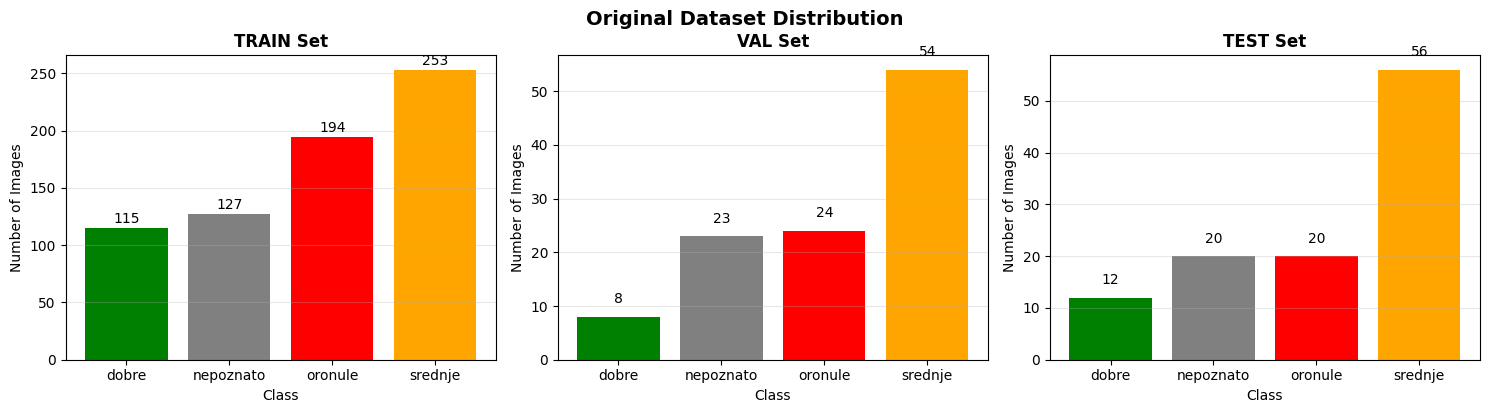

In [15]:
# Visualize distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, split in enumerate(SPLITS):
    classes = list(original_counts[split].keys())
    counts = list(original_counts[split].values())
    
    axes[idx].bar(classes, counts, color=['green', 'gray', 'red', 'orange'])
    axes[idx].set_title(f'{split.upper()} Set', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Class')
    axes[idx].set_ylabel('Number of Images')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add count labels
    for i, count in enumerate(counts):
        axes[idx].text(i, count + 2, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.suptitle('Original Dataset Distribution', fontsize=14, fontweight='bold', y=1.02)
plt.show()


## 6. Visualize Augmentation Examples


In [16]:
# Load a random sample image
sample_class = random.choice(CLASSES)
sample_dir = os.path.join(ORIGINAL_DIR, "train", sample_class)
sample_images = [f for f in os.listdir(sample_dir) if f.endswith('.jpg')]
sample_img_path = os.path.join(sample_dir, random.choice(sample_images))

# Read image
image = cv2.imread(sample_img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(f"Sample image: {sample_img_path}")
print(f"Class: {sample_class}")
print(f"Image shape: {image.shape}")


Sample image: slike_kuce_bgns/train/nepoznato/kuca_112.jpg
Class: nepoznato
Image shape: (400, 600, 3)


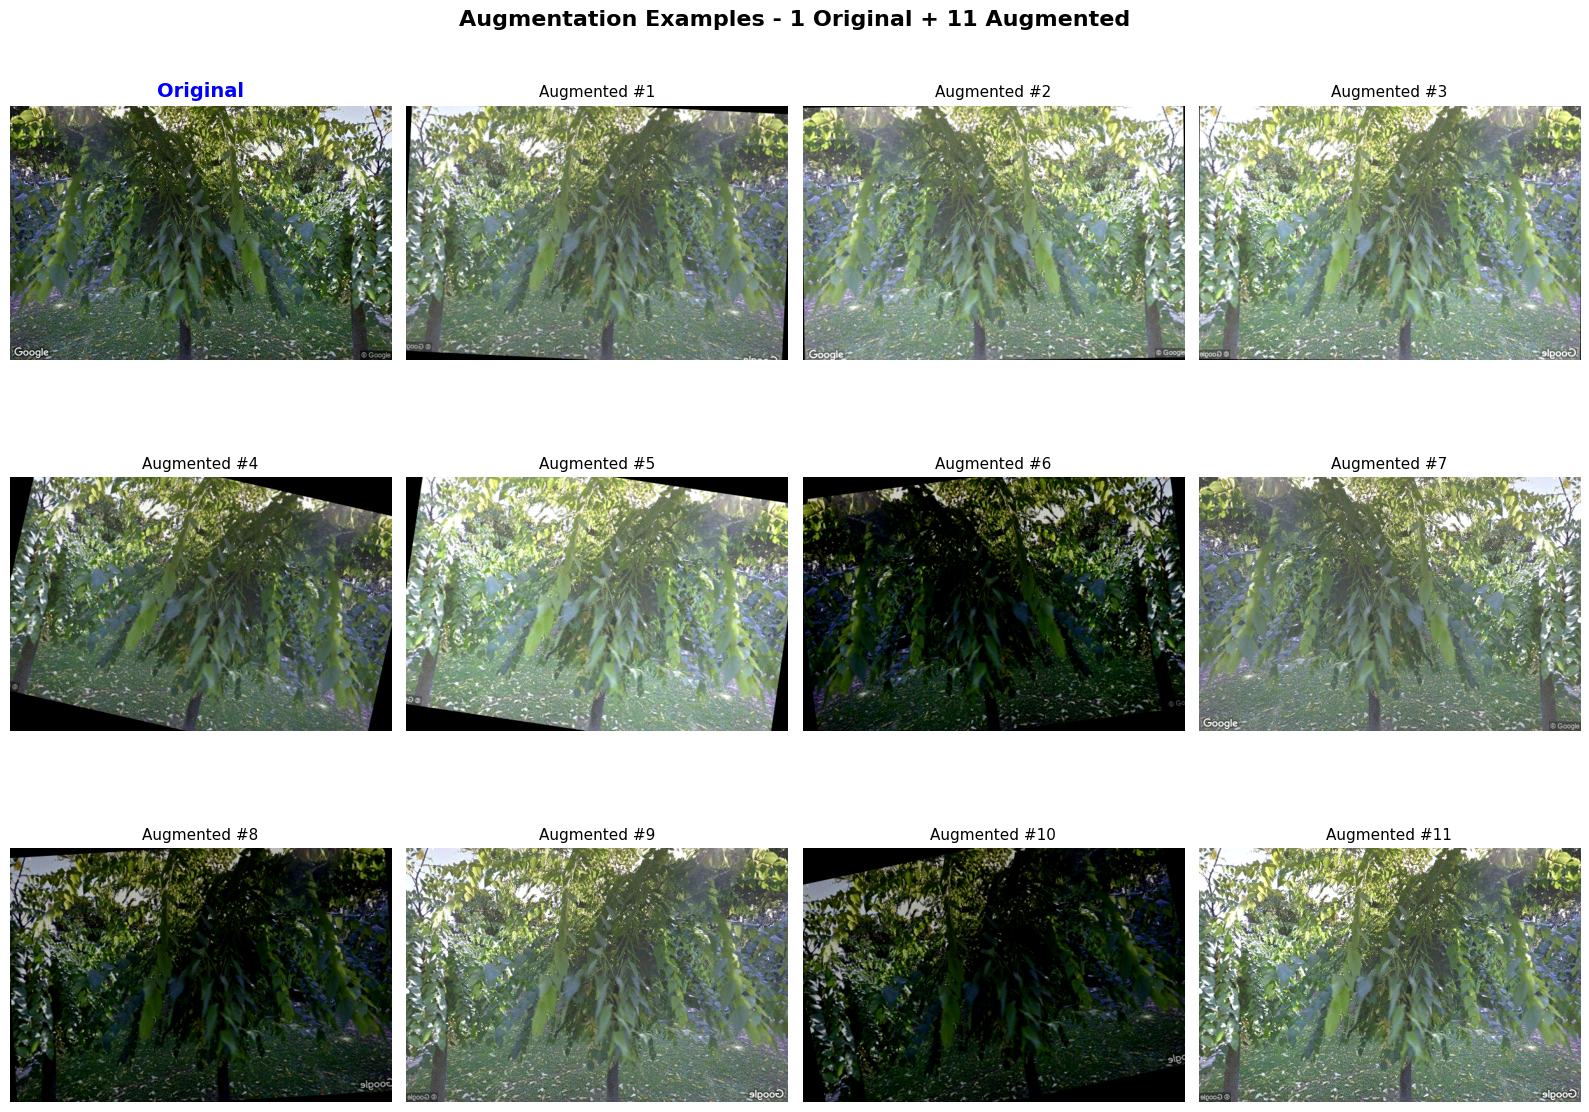

In [17]:
# Show original + 11 augmented versions
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

# Original
axes[0].imshow(image)
axes[0].set_title('Original', fontsize=14, fontweight='bold', color='blue')
axes[0].axis('off')

# Augmented versions
for i in range(1, 12):
    augmented = augmentation_pipeline(image=image)["image"]
    axes[i].imshow(augmented)
    axes[i].set_title(f'Augmented #{i}', fontsize=11)
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Augmentation Examples - 1 Original + 11 Augmented', fontsize=16, fontweight='bold', y=0.995)
plt.show()


## 7. Create Folder Structure


In [ ]:
def create_folder_structure(base_dir):
    """Create train/val/test splits with class folders."""
    for split in SPLITS:
        for class_name in CLASSES:
            folder_path = os.path.join(base_dir, split, class_name)
            os.makedirs(folder_path, exist_ok=True)
    print(f"✅ Created folder structure in: {base_dir}")

# Create both output directories
create_folder_structure(AUGMENTED_DIR)
create_folder_structure(WHOLE_DIR)

print("\nFolder structure created:")
print(f"  {AUGMENTED_DIR}/")
print(f"    ├── train/")
print(f"    │   ├── dobre/")
print(f"    │   ├── nepoznato/")
print(f"    │   ├── oronule/")
print(f"    │   └── srednje/")
print(f"    ├── val/...")
print(f"    └── test/...")
print(f"\n  {WHOLE_DIR}/... (same structure)")


## 8. Perform Augmentation

This will:
1. Process all images in all splits (train/val/test)
2. Create augmented versions and save to `slike_kuce_bgns_augmented`
3. Copy originals to `slike_kuce_bgns_whole`
4. Copy augmented to `slike_kuce_bgns_whole`


In [ ]:
def augment_dataset():
    """Augment all images in the dataset."""
    total_original = 0
    total_augmented = 0
    
    print("Starting augmentation process...")
    print("=" * 70)
    
    for split in SPLITS:
        print(f"\n📁 Processing {split.upper()} set...")
        
        for class_name in CLASSES:
            # Source folder
            source_folder = os.path.join(ORIGINAL_DIR, split, class_name)
            
            # Destination folders
            aug_folder = os.path.join(AUGMENTED_DIR, split, class_name)
            whole_folder = os.path.join(WHOLE_DIR, split, class_name)
            
            if not os.path.exists(source_folder):
                continue
            
            # Get all original images
            original_images = [f for f in os.listdir(source_folder) if f.endswith('.jpg')]
            
            if not original_images:
                continue
            
            print(f"  {class_name:12s}: {len(original_images):4d} images", end="")
            
            aug_count = 0
            
            # Process each image
            for img_name in tqdm(original_images, desc=f"    Augmenting", leave=False):
                img_path = os.path.join(source_folder, img_name)
                
                # Read image
                image = cv2.imread(img_path)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # Copy original to whole folder
                shutil.copy2(img_path, os.path.join(whole_folder, img_name))
                
                # Create augmented versions
                base_name = os.path.splitext(img_name)[0]
                
                for aug_idx in range(AUGMENTATIONS_PER_IMAGE):
                    # Apply augmentation
                    augmented = augmentation_pipeline(image=image_rgb)["image"]
                    augmented_bgr = cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR)
                    
                    # Save augmented image
                    aug_name = f"{base_name}_aug_{aug_idx+1}.jpg"
                    
                    # Save to augmented folder
                    aug_path = os.path.join(aug_folder, aug_name)
                    cv2.imwrite(aug_path, augmented_bgr)
                    
                    # Save to whole folder
                    whole_path = os.path.join(whole_folder, aug_name)
                    cv2.imwrite(whole_path, augmented_bgr)
                    
                    aug_count += 1
            
            print(f" → {aug_count:4d} augmented")
            total_original += len(original_images)
            total_augmented += aug_count
    
    print("\n" + "=" * 70)
    print("✅ Augmentation completed!")
    print(f"\nTotal original images: {total_original}")
    print(f"Total augmented images: {total_augmented}")
    print(f"Total images in 'whole' folder: {total_original + total_augmented}")
    
    return total_original, total_augmented

# Run augmentation
orig_count, aug_count = augment_dataset()


## 9. Verify Results


In [ ]:
# Count images in all folders
augmented_counts = count_images_in_dataset(AUGMENTED_DIR)
whole_counts = count_images_in_dataset(WHOLE_DIR)

print("\n📊 VERIFICATION RESULTS")
print("=" * 80)

for split in SPLITS:
    print(f"\n{split.upper()}:")
    print(f"  {'Class':12s} {'Original':>10s} {'Augmented':>12s} {'Whole':>10s}")
    print("  " + "-" * 48)
    
    for class_name in CLASSES:
        orig = original_counts[split][class_name]
        aug = augmented_counts[split][class_name]
        whole = whole_counts[split][class_name]
        print(f"  {class_name:12s} {orig:10d} {aug:12d} {whole:10d}")
    
    total_orig = sum(original_counts[split].values())
    total_aug = sum(augmented_counts[split].values())
    total_whole = sum(whole_counts[split].values())
    print("  " + "-" * 48)
    print(f"  {'TOTAL':12s} {total_orig:10d} {total_aug:12d} {total_whole:10d}")

print("\n" + "=" * 80)


In [ ]:
# Visualize comparison
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for split_idx, split in enumerate(SPLITS):
    # Original
    classes = list(original_counts[split].keys())
    orig_counts_list = list(original_counts[split].values())
    
    axes[split_idx, 0].bar(classes, orig_counts_list, color=['green', 'gray', 'red', 'orange'])
    axes[split_idx, 0].set_title(f'{split.upper()} - Original', fontweight='bold')
    axes[split_idx, 0].set_ylabel('Count')
    axes[split_idx, 0].grid(axis='y', alpha=0.3)
    for i, count in enumerate(orig_counts_list):
        axes[split_idx, 0].text(i, count + 2, str(count), ha='center', va='bottom', fontsize=9)
    
    # Augmented
    aug_counts_list = list(augmented_counts[split].values())
    axes[split_idx, 1].bar(classes, aug_counts_list, color=['green', 'gray', 'red', 'orange'], alpha=0.7)
    axes[split_idx, 1].set_title(f'{split.upper()} - Augmented Only', fontweight='bold')
    axes[split_idx, 1].grid(axis='y', alpha=0.3)
    for i, count in enumerate(aug_counts_list):
        axes[split_idx, 1].text(i, count + 2, str(count), ha='center', va='bottom', fontsize=9)
    
    # Whole
    whole_counts_list = list(whole_counts[split].values())
    axes[split_idx, 2].bar(classes, whole_counts_list, color=['green', 'gray', 'red', 'orange'], alpha=0.8)
    axes[split_idx, 2].set_title(f'{split.upper()} - Whole (Orig + Aug)', fontweight='bold')
    axes[split_idx, 2].grid(axis='y', alpha=0.3)
    for i, count in enumerate(whole_counts_list):
        axes[split_idx, 2].text(i, count + 2, str(count), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.suptitle('Dataset Comparison: Original vs Augmented vs Whole', fontsize=16, fontweight='bold', y=1.01)
plt.show()


## 10. Sample Augmented Images


In [ ]:
# Show some examples from the augmented folder
def show_augmentation_samples(split="train", num_samples=1):
    """Show original vs augmented images side by side."""
    
    for class_name in CLASSES:
        print(f"\n{'='*60}")
        print(f"Class: {class_name.upper()}")
        print(f"{'='*60}")
        
        # Get folders
        orig_folder = os.path.join(ORIGINAL_DIR, split, class_name)
        aug_folder = os.path.join(AUGMENTED_DIR, split, class_name)
        
        # Get original images
        orig_images = [f for f in os.listdir(orig_folder) if f.endswith('.jpg') and '_aug_' not in f]
        
        if not orig_images:
            continue
        
        # Sample some originals
        samples = random.sample(orig_images, min(num_samples, len(orig_images)))
        
        for orig_name in samples:
            # Read original
            orig_path = os.path.join(orig_folder, orig_name)
            orig_img = cv2.imread(orig_path)
            orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
            
            # Find augmented versions
            base_name = os.path.splitext(orig_name)[0]
            aug_images = [f for f in os.listdir(aug_folder) if f.startswith(base_name + '_aug_')]
            
            # Display
            num_cols = 1 + len(aug_images)
            fig, axes = plt.subplots(1, num_cols, figsize=(5*num_cols, 5))
            
            if num_cols == 1:
                axes = [axes]
            
            # Show original
            axes[0].imshow(orig_img)
            axes[0].set_title('Original', fontsize=12, fontweight='bold')
            axes[0].axis('off')
            
            # Show augmented versions
            for idx, aug_name in enumerate(sorted(aug_images)):
                aug_path = os.path.join(aug_folder, aug_name)
                aug_img = cv2.imread(aug_path)
                aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)
                
                axes[idx+1].imshow(aug_img)
                axes[idx+1].set_title(f'Augmented {idx+1}', fontsize=12, fontweight='bold')
                axes[idx+1].axis('off')
            
            plt.tight_layout()
            plt.suptitle(f'{orig_name}', fontsize=10, y=0.98)
            plt.show()

# Show samples from training set
show_augmentation_samples(split="train", num_samples=1)


## 11. Final Summary


In [ ]:
print("\n" + "="*80)
print("📊 FINAL SUMMARY")
print("="*80)

print("\n✅ Augmentation Process Completed!")

print("\n📁 Output Folders Created:")
print(f"\n1. {AUGMENTED_DIR}/")
print("   - Contains ONLY augmented images")
print("   - Same structure as original (train/val/test)")

print(f"\n2. {WHOLE_DIR}/")
print("   - Contains BOTH original AND augmented images")
print("   - Ready to use for training")
print("   - Augmented files have '_aug_' in their names")

print("\n🎨 Augmentation Techniques Used:")
print("   1. Horizontal Flip")
print("   2. Brightness/Contrast Adjustment")
print("   3. Rotation (±15°)")

total_orig_all = sum(sum(original_counts[split].values()) for split in SPLITS)
total_aug_all = sum(sum(augmented_counts[split].values()) for split in SPLITS)
total_whole_all = sum(sum(whole_counts[split].values()) for split in SPLITS)

print("\n📈 Statistics Across All Splits:")
print(f"   Original images:  {total_orig_all:5d}")
print(f"   Augmented images: {total_aug_all:5d}")
print(f"   Total in 'whole': {total_whole_all:5d}")
print(f"   Dataset increase: {(total_whole_all/total_orig_all - 1)*100:.1f}%")

print("\n🚀 Next Steps:")
print("   1. Use 'slike_kuce_bgns_whole' as your data_dir for training")
print("   2. Modify fine_tune_vit.ipynb to point to the new folder")
print("   3. Train and compare results with original dataset")

print("\n" + "="*80)


## 📝 Notes

### Folder Organization:

```
slike_kuce_bgns/              # Original (unchanged)
├── train/
├── val/
└── test/

slike_kuce_bgns_augmented/    # Only augmented images
├── train/
├── val/
└── test/

slike_kuce_bgns_whole/        # Original + Augmented (use this for training!)
├── train/
├── val/
└── test/
```

### Augmentation Techniques Chosen:

These 3 techniques were selected as the **most reliable** for building images:

1. **Horizontal Flip (66%)** - Very natural, buildings look fine from either side. With 1 original + 3 augmented, this gives roughly 2:2 split.
2. **Brightness/Contrast (100%)** - Common due to different times of day, weather conditions. Always applied but with conservative contrast (±15%) to preserve quality.
3. **Rotation (66%, ±15°)** - Realistic camera angle variations. Higher probability ensures good variety.

### Why These 3?

✅ **Advantages:**
- No artifacts or unrealistic features
- Preserves structural integrity of buildings
- Simulates real-world photography variations
- Computationally efficient
- Proven to work well with CNN/ViT architectures

❌ **Excluded techniques:**
- Vertical flip (unrealistic)
- Heavy noise/blur (might hurt quality)
- Extreme transformations (could alter condition assessment)

### Expected Results:

With uniform augmentation:
- Better generalization
- Reduced overfitting
- More robust to lighting/angle variations
- Improved overall accuracy
